### Required Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE

### Read Data

In [2]:
CONS_FILE = "Consolidated_A_B_minimal.csv"
IMP_A_FILE = "univariate_importance_regressor_WCCT.csv"
IMP_B_FILE = "univariate_importance_regressor_VXA.csv"
#Parameters
EDGE_CUTOFF = 0.70
TSNE_SEED = 42
TSNE_PERPLEXITY = 10
TSNE_MAX_ITER = 1200
SIZE_MIN = 200
SIZE_MAX = 1800
DPI = 300

In [3]:
cons = pd.read_csv(CONS_FILE)
impA = pd.read_csv(IMP_A_FILE)
impB = pd.read_csv(IMP_B_FILE)

### Cleaning

In [4]:
def clean_text(x: str) -> str:
    return str(x).strip().replace("_", " ").replace(".", " ")

In [5]:
cons["Consolidated Name"] = cons["Consolidated Name"].apply(clean_text)
impA["population"] = impA["population"].apply(clean_text)
impB["population"] = impB["population"].apply(clean_text)

### Match cell populations

In [6]:
valid_pops = sorted(set(cons["Consolidated Name"]) & set(impA["population"]) & set(impB["population"]))
cons = cons[cons["Consolidated Name"].isin(valid_pops)]
impA = impA[impA["population"].isin(valid_pops)]
impB = impB[impB["population"].isin(valid_pops)]

### Category colors

In [7]:
def norm_cat(c):
    if pd.isna(c): return "Other"
    return str(c).strip()

In [8]:
import matplotlib as mpl
import matplotlib.cm as cm
cats = sorted(cons["Category"].unique())
cmap = mpl.colormaps.get_cmap("tab20").resampled(len(cats))
CAT2COLOR = {cat: cm.colors.to_hex(cmap(i)) for i, cat in enumerate(cats)}

In [9]:
def pick_importance(df):
    if "neglog10p" in df.columns:
        return "neglog10p"
    elif "R2_from_rho" in df.columns:
        return "R2_from_rho"
    else:
        raise ValueError("Importance columns not found.")

In [10]:
IMP_COL_A = "R2_from_rho"
IMP_COL_B = "R2_from_rho"

In [11]:
def build_profiles(df_cons):
    mat = df_cons.pivot_table(index="Consolidated Name", columns="reagent",
                              values="median", aggfunc="mean")
    mat = mat.apply(lambda col: (col - col.mean()) / (col.std(ddof=0) or 1.0))
    return mat.fillna(0.0)

In [12]:
def corr_populations(mat):
    return mat.T.corr(method="spearman")

### Pooled data

In [13]:
pooled_cons = (
    cons.groupby(["Category", "Consolidated Name", "reagent"], as_index=False)
        .agg(median=("median", "mean"))
)
pooled_cons["Study"] = "Pooled"

In [14]:
mat_pooled = build_profiles(pooled_cons)
pops_order = mat_pooled.index.tolist()

In [15]:
tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, max_iter=TSNE_MAX_ITER,
            random_state=TSNE_SEED, init="random", learning_rate="auto")
xy = tsne.fit_transform(mat_pooled.values)
pos_tsne = {p: xy[i] for i, p in enumerate(pops_order)}

In [16]:
#Ensure the same layout every run
import os
if os.path.exists("fixed_layout.npy"):
    pos_tsne = np.load("fixed_layout.npy", allow_pickle=True).item()
else:
    np.save("fixed_layout.npy", pos_tsne)

In [17]:
def spring_relax(G, pos_init):
    return nx.spring_layout(G, pos=pos_init, seed=TSNE_SEED, k=6.0, iterations=900)

In [18]:
def repel_positions(pos, sizes, pad=0.06, steps=1400, lr=0.05):
    names = list(pos.keys())
    pts = np.array([pos[n] for n in names])
    pts = (pts - pts.min(0)) / (pts.max(0) - pts.min(0) + 1e-9)
    arr_sizes = np.array([sizes[n] for n in names])
    rad = np.sqrt(arr_sizes)
    rad = (rad - rad.min()) / (rad.max() - rad.min() + 1e-9) * 0.05 + 0.02
    for _ in range(steps):
        moved = False
        for i in range(len(pts)):
            for j in range(i+1, len(pts)):
                d = pts[i] - pts[j]
                dist = np.linalg.norm(d) + 1e-12
                min_d = rad[i] + rad[j] + pad
                if dist < min_d:
                    push = (min_d - dist) * (d / dist)
                    pts[i] += lr * push
                    pts[j] -= lr * push
                    moved = True
        if not moved:
            break
    pts = (pts - pts.mean(0)) * 1.8
    return {n: p for n, p in zip(names, pts)}

In [19]:
def widen_positions(pos: dict, factor: float = 0.25) -> dict:
    pts = np.vstack([np.asarray(v, float) for v in pos.values()])
    cx, cy = pts.mean(axis=0)
    return {k: (np.asarray(v, float) - [cx, cy]) * factor + [cx, cy] for k, v in pos.items()}

In [20]:
def scale_sizes(values):
    v = values.replace([np.inf, -np.inf], np.nan).fillna(0).clip(lower=0)
    vmin, vmed, vmax = float(v.min()), float(v.median()), float(v.max())
    if vmax == vmin:
        scaled = pd.Series(SIZE_MIN, index=v.index)
    else:
        scaled = SIZE_MIN + (v - vmin) / (vmax - vmin) * (SIZE_MAX - SIZE_MIN)
    return scaled, {"min": vmin, "median": vmed, "max": vmax}

In [21]:
def build_graph(cons_subset, imp_table, imp_col, pos_base):
    mat = build_profiles(cons_subset)
    corr = corr_populations(mat)
    pops = mat.index.tolist()

    imp_series = imp_table.set_index("population")[imp_col].reindex(pops).fillna(0)
    sizes, legend_stats = scale_sizes(imp_series)

    cat_map = cons.set_index("Consolidated Name")["Category"].to_dict()
    colors = {p: CAT2COLOR.get(cat_map.get(p, "Other"), "#BBBBBB") for p in pops}

    G = nx.Graph()
    for p in pops:
        G.add_node(p, size=float(sizes.loc[p]), color=colors[p])
    for i in range(len(pops)):
        for j in range(i+1, len(pops)):
            val = corr.iloc[i, j]
            if np.isfinite(val) and abs(val) >= EDGE_CUTOFF:
                G.add_edge(pops[i], pops[j], weight=float(val))

    # Ensure all nodes connected
    comps = list(nx.connected_components(G))
    if len(comps) > 1:
        for i in range(len(comps) - 1):
            n1 = list(comps[i])[0]
            n2 = list(comps[i + 1])[0]
            G.add_edge(n1, n2, weight=0.01)

    pos_relax = nx.spring_layout(G, seed=TSNE_SEED, k=3.5, iterations=3000)
    size_map = {p: float(sizes.loc[p]) for p in pops}
    pos_clean = repel_positions(pos_relax, size_map, pad=0.06, steps=1400, lr=0.05)
    return G, pos_clean, legend_stats

### Building Networks

In [22]:
def draw_graph(G, pos, title, legend_stats, png_name):
    plt.figure(figsize=(10, 8))
    pos = widen_positions(pos, factor=0.5)  
    nx.draw_networkx_edges(G, pos, alpha=0.35, width=0.9, edge_color="#666666")
    ns = [G.nodes[n]["size"] for n in G.nodes()]
    nc = [G.nodes[n]["color"] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=ns, node_color=nc,
                           edgecolors="white", linewidths=0.7, alpha=0.98)
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                          markerfacecolor=CAT2COLOR[cat], markersize=9)
               for cat in cats]
    leg1 = plt.legend(
    handles=handles,
    title="Category",
    loc="upper left",
    bbox_to_anchor=(-0.02, 0.25),  
    frameon=False
)
    plt.gca().add_artist(leg1)
    s_min, s_med, s_max = SIZE_MIN, SIZE_MIN + (SIZE_MAX - SIZE_MIN)*0.5, SIZE_MAX
    for lab, sval in [
        (f"min = {legend_stats['min']:.2f}", s_min),
        (f"med = {legend_stats['median']:.2f}", s_med),
        (f"max = {legend_stats['max']:.2f}", s_max)
    ]:
        plt.scatter([], [], s=sval, c="#777777", edgecolors="white", linewidths=0.6, label=lab)
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1.0,
               title="Importance (R² from univariate analysis)", loc="upper right")

    plt.title(title, fontsize=18, fontweight="bold")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(png_name, dpi=DPI)
    plt.show()

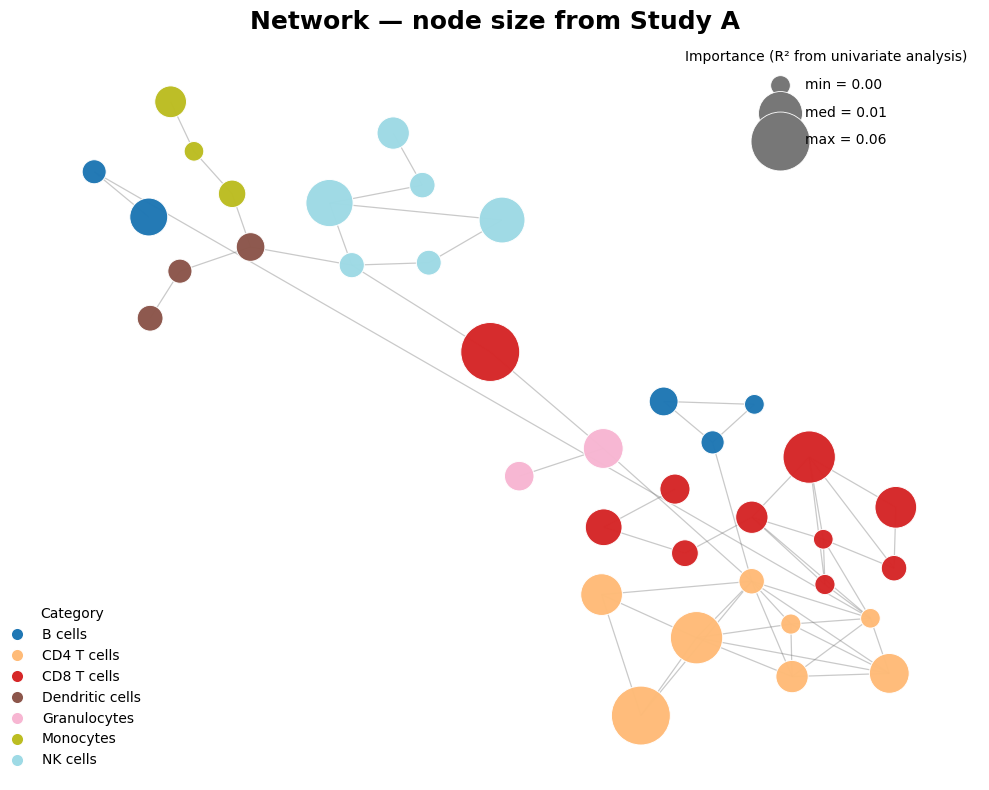

In [23]:
cons_P = pooled_cons.rename(columns={"Consolidated Name": "Consolidated Name"})
G_PA, posPA, legPA = build_graph(cons_P, impA, IMP_COL_A, pos_tsne)
draw_graph(G_PA, posPA, "Network — node size from Study A", legPA, "Network_Pooled_A.png")

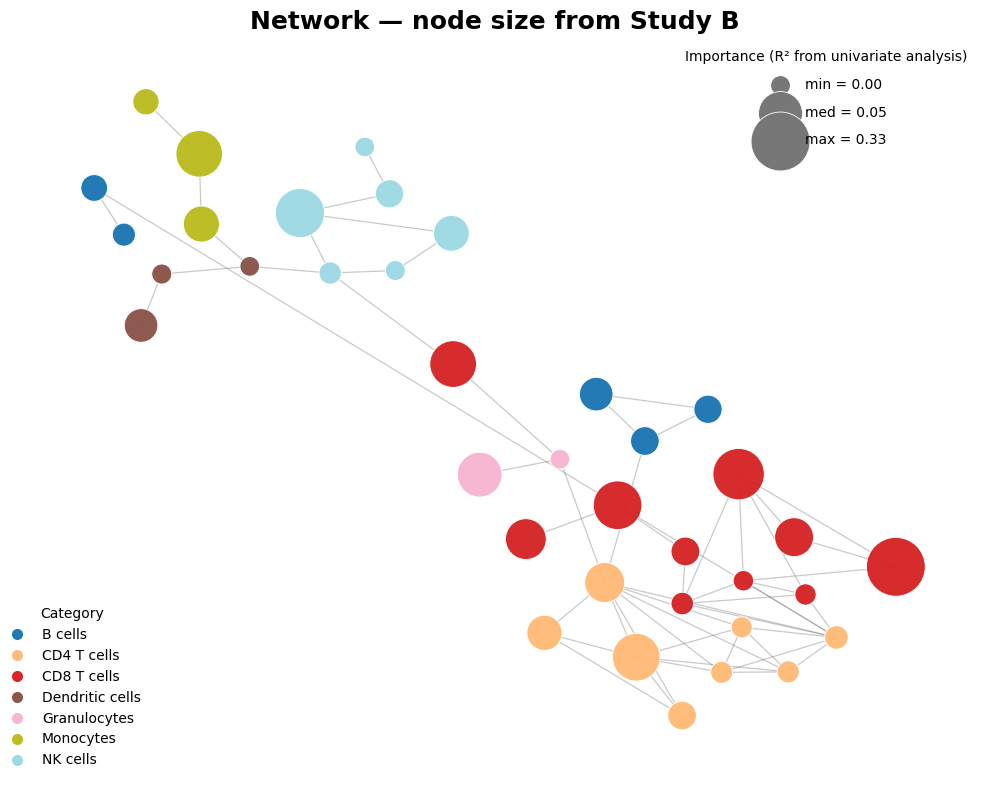

In [24]:
G_PB, posPB, legPB = build_graph(cons_P, impB, IMP_COL_B, pos_tsne)
draw_graph(G_PB, posPB, "Network — node size from Study B", legPB, "Network_Pooled_B.png")